In [2]:
import wandb
from wandb.integration.keras import WandbCallback
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alvaro-francisco-gil (orbit-generation). Use `wandb login --relogin` to force relogin


True

# Imports

In [2]:
import tensorflow as tf

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs found: {len(gpus)}")

# Print GPU details
for i, gpu in enumerate(gpus):
    print(f"GPU {i}: {gpu}")

# Assuming 'GPU:1' is the identifier for the second GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Disable first GPU
        tf.config.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Logical GPUs:", logical_gpus)
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)



GPUs found: 2
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


2024-05-18 09:34:54.244577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-18 09:34:54.244706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-18 09:34:54.247748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-18 09:34:54.247839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-18 09:34:54.247917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [4]:
from orbit_generation.data import load_memmap_array, save_data
from orbit_generation.processing import resample_3d_array
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits
from orbit_generation.stats import plot_histograms_comparison, plot_latent_space
from orbit_generation.model import get_optimizer

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tensorflow import keras
import tsgm
import os

2024-05-19 08:36:25.867269: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 08:36:27.390003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-19 08:36:27.390171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-19 08:36:27.393638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-19 08:36:27.393743: I tensorflow/strea

# Parameters

In [1]:
data_path = r"/orbit-generation/data/sp_dataset_em.npy"
labels_path = r"/orbit-generation/data/sp_dataset_em_labels.npy"
folder_experiments = "../experiments"

In [6]:
params = {
    'model_name': 'vae_conv5',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 16,
    'feature_dim': 7,
    'seq_len': 300,
    'batch_size': 32,
    'epochs': 25,
    'optimizer': {
        'name': 'Adam',
        'learning_rate': 0.001
    }
}

## Create Experiment Folder

In [7]:
# Extract relevant parameters
model_name = params['model_name']
data_used = params['data_used']

# Combine the remaining parameters into a single string to form the last subdirectory name
# Excluding 'model_name' and 'data_used' since they're used in higher-level directories
other_params = f"{params['latent_dim']}_{params['feature_dim']}_{params['seq_len']}_{params['batch_size']}_{params['epochs']}_{params['optimizer']['name']}_{params['optimizer']['learning_rate']}"

# Construct the full path for the experiment directory
experiment_folder = os.path.join(folder_experiments, model_name, data_used, other_params)

# Create the directory structure
os.makedirs(experiment_folder, exist_ok=True)

# Now you can use 'experiment_folder' to save files related to this particular experiment
print(f"Experiment directory created: {experiment_folder}")

Experiment directory created: ../experiments/vae_conv5/sp_dataset_em/64_7_300_32_25_Adam_0.001


In [11]:
# Initialize a new run
wandb.init(project='orbit-generation', entity='alvaro-francisco-gil', config=params)

wandb: Currently logged in as: alvaro-francisco-gil. Use `wandb login --relogin` to force relogin


# Data

## Imports

In [42]:
data = load_memmap_array(data_path)
data.shape

(163800, 7, 1500)

In [15]:
labels = np.load(labels_path)
labels.shape

(163800,)

## Interpolation

In [43]:
data = resample_3d_array(data=data, axis=2, target_size=params['seq_len'])
data.shape

(163800, 7, 300)

## Shuffle

In [44]:
# Set a random seed for reproducibility
np.random.seed(42) 

# Create an array of indices based on the length of the data
indices = np.arange(data.shape[0])

# Shuffle the indices
np.random.shuffle(indices)

# Use the shuffled indices to reorder the data and labels
data = data[indices]
labels = labels[indices]

## Transpose

In [18]:
transposed_orbits = np.transpose(data, (0, 2, 1))

## Scaling

In [19]:
scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(transposed_orbits)
del transposed_orbits
scaled_data.shape

(163800, 300, 7)

# Generation

## Define Architecture

In [18]:
# Accessing model configuration from the zoo using parameters from the dictionary
architecture = tsgm.models.zoo[params['model_name']](
    seq_len=params['seq_len'], 
    feat_dim=params['feature_dim'], 
    latent_dim=params['latent_dim']
)

# Extracting encoder and decoder from the architecture
encoder, decoder = architecture.encoder, architecture.decoder

## Fit

In [20]:
# Assuming encoder and decoder have been defined as part of the architecture setup
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)

# Compile the VAE model with the configured optimizer from the params dictionary
optimizer = get_optimizer(params['optimizer'])
vae.compile(optimizer=optimizer)

# Fit the model using the scaled data and parameters from the dictionary
vae.fit(scaled_data, epochs=params['epochs'], batch_size=params['batch_size'], callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/25


2024-05-17 15:06:22.906281: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


   6/5119 [..............................] - ETA: 4:29 - loss: 1401.9878 - reconstruction_loss: 974.0891 - kl_loss: 2.3143 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0171s vs `on_train_batch_end` time: 0.0298s). Check your callbacks.


5119/5119 [==============================] - 270s 52ms/step - loss: 122.9322 - reconstruction_loss: 57.5479 - kl_loss: 9.1532
Epoch 2/25
5119/5119 [==============================] - 267s 52ms/step - loss: 21.0802 - reconstruction_loss: 12.3095 - kl_loss: 7.8099
Epoch 3/25
5119/5119 [==============================] - 267s 52ms/step - loss: 17.5139 - reconstruction_loss: 10.0666 - kl_loss: 7.1566
Epoch 4/25
5119/5119 [==============================] - 267s 52ms/step - loss: 19.1945 - reconstruction_loss: 10.2943 - kl_loss: 7.3199
Epoch 5/25
5119/5119 [==============================] - 267s 52ms/step - loss: 16.5271 - reconstruction_loss: 9.1896 - kl_loss: 7.2548
Epoch 6/25
5119/5119 [==============================] - 267s 52ms/step - loss: 15.8818 - reconstruction_loss: 8.6869 - kl_loss: 7.1240
Epoch 7/25
5119/5119 [==============================] - 267s 52ms/step - loss: 15.3302 - reconstruction_loss: 8.2352 - kl_loss: 7.0129
Epoch 8/25
5119/5119 [==============================] - 267s 

## Save Model

In [9]:
# Define full paths for the encoder and decoder
encoder_save_path = os.path.join(experiment_folder, 'encoder')
decoder_save_path = os.path.join(experiment_folder, 'decoder')

In [8]:
# Save the models in the specified directory with TensorFlow format
encoder.save(encoder_save_path, save_format='tf')
decoder.save(decoder_save_path, save_format='tf')

wandb.save('encoder.h5')
wandb.save('decoder.h5')
wandb.save('generation.npy')

NameError: name 'encoder' is not defined

In [12]:
"""
encoder = tf.keras.models.load_model(encoder_save_path)
decoder = tf.keras.models.load_model(decoder_save_path)

# Assuming encoder and decoder have been defined as part of the architecture setup
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)
"""

## Predict

In [20]:
x_decoded = vae.predict(scaled_data)

2024-05-19 08:39:02.962661: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


5119/5119 [==============================] - 71s 14ms/step


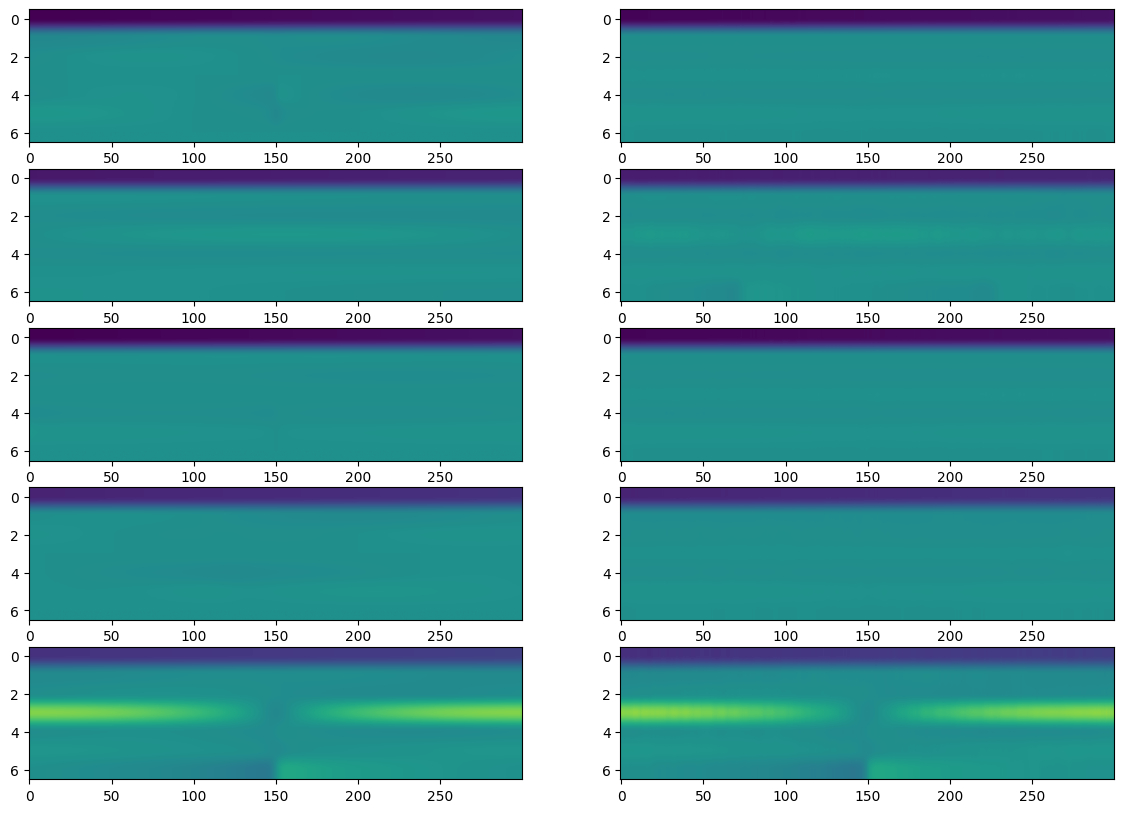

In [21]:
tsgm.utils.visualize_original_and_reconst_ts(scaled_data, x_decoded, num=5)

## Generate

In [24]:
# generation = vae.generate(int(data.shape[0]*0.01))
generation = vae.generate(100)
generation.shape

TensorShape([100, 300, 7])

In [28]:
generated_data_path = os.path.join(experiment_folder, 'generated_data.npy')
print(generated_data_path)

../experiments/vae_conv5/sp_dataset_em/64_7_300_32_25_Adam_0.001/generated_data.npy


In [30]:
inverted_generation = scaler.inverse_transform(generation)
np.save(generated_data_path, inverted_generation)

In [ ]:
# generation = np.load(generated_data_path)

# Analysis

## Visualization

Get a Random Sampling

In [31]:
no_time_generation = inverted_generation[:,:,1:]
no_time_generation.shape

TensorShape([100, 300, 6])

In [32]:
display_generation = np.transpose(no_time_generation, (0, 2, 1))

In [ ]:
static_all_orbit_path = os.path.join(experiment_folder, 'all_generated_data.png')
static_some_orbit_path = os.path.join(experiment_folder, 'some_generated_data.png')

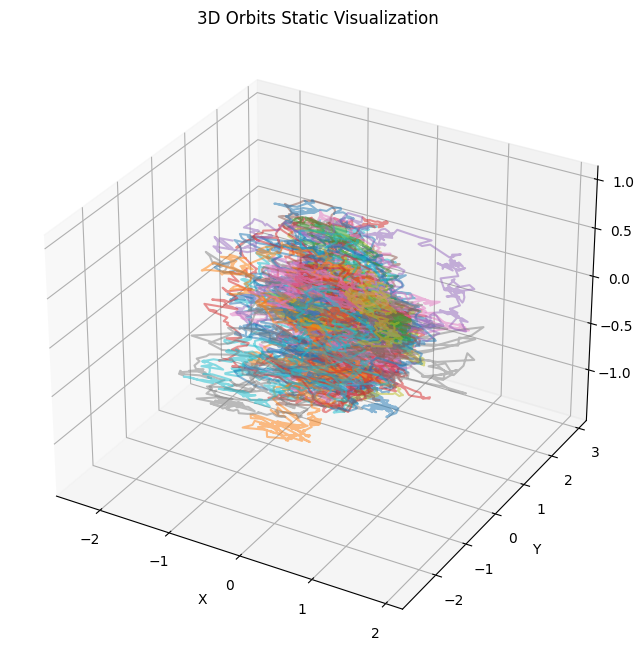

In [38]:
visualize_static_orbits(data= display_generation, show_legend=False, save_path=static_all_orbit_path)

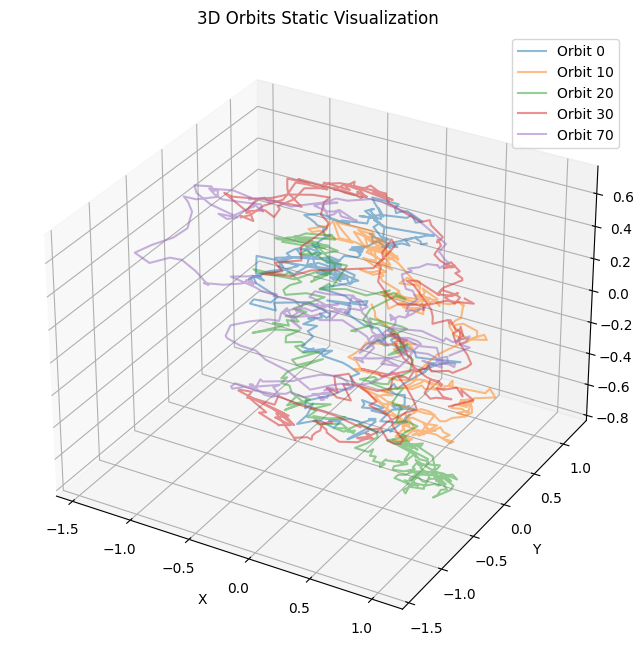

In [39]:
visualize_static_orbits(data= display_generation, orbit_indices=[0,10,20,30,70], save_path=static_some_orbit_path)

In [40]:
dynamic_orbits_path = os.path.join(experiment_folder, 'generated_orbits.html')
export_dynamic_orbits_html(data=display_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/vae_conv5/sp_dataset_em/64_7_300_32_25_Adam_0.001/generated_orbits.html


## Coverage

In [45]:
data = data[:,1:,:]

np.random.seed(42)

# Number of samples to draw
num_samples = 1000

# Randomly choose indices
random_indices = np.random.choice(data.shape[0], size=num_samples, replace=False)

# Select the samples
sampled_data = data[random_indices]
sampled_labels = labels[random_indices]

sampled_data.shape

In [ ]:
scaled_data = scaled_data[random_indices]
scaled_data.shape

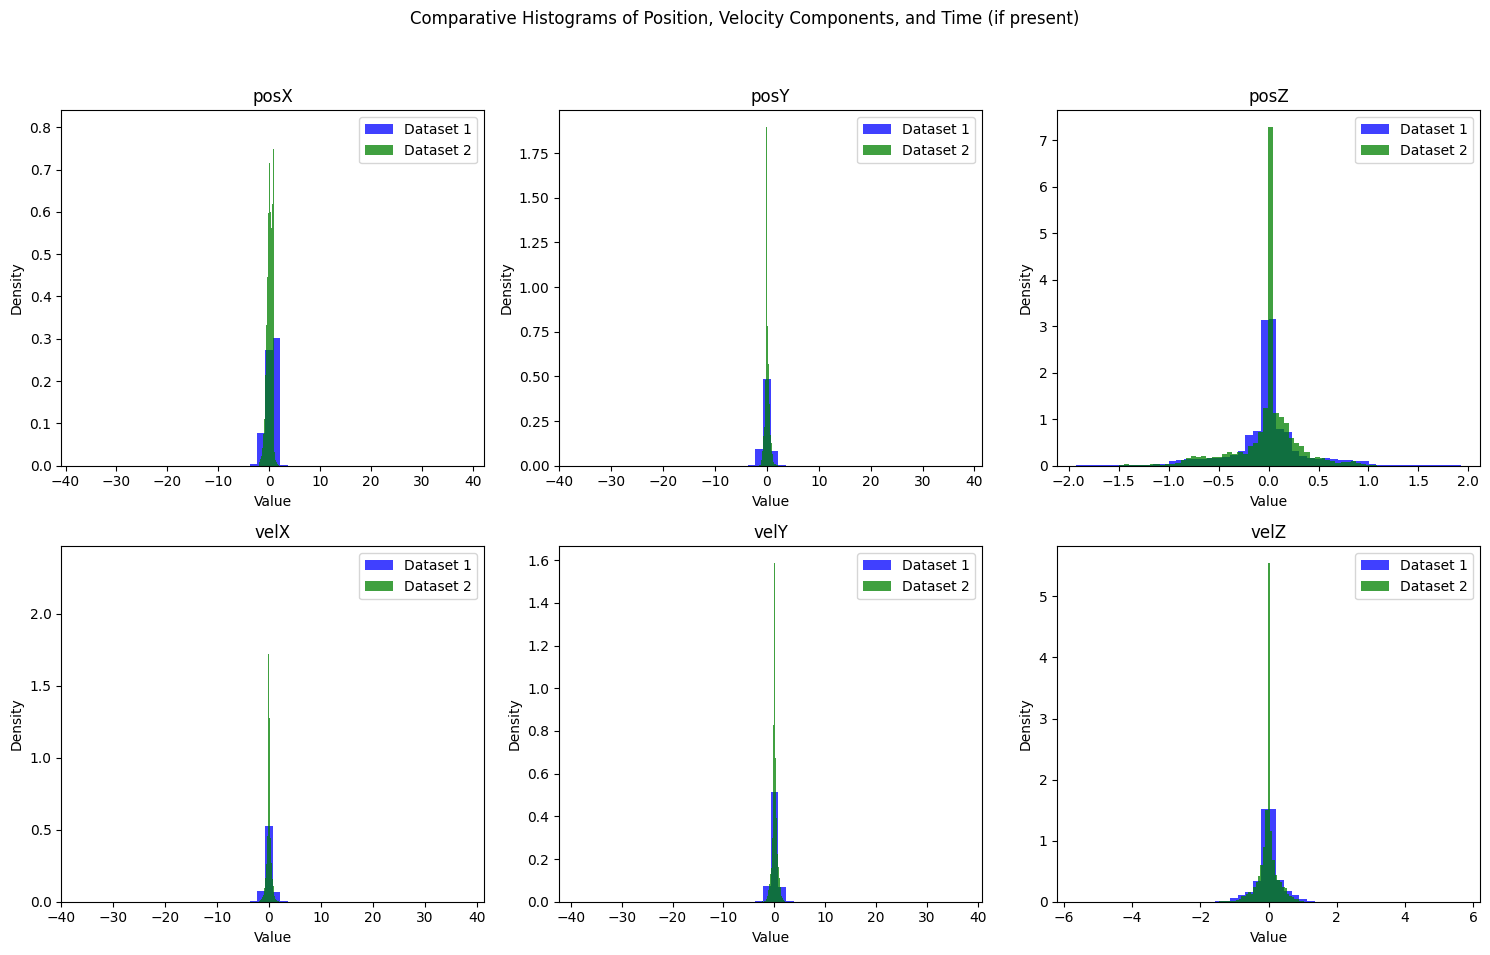

In [46]:
plot_histograms_comparison(data1=data, data2=display_generation, label1='Real', label2='Synthetic', normalize=True)

## Latent Visualization

In [47]:
latent_mean, _, _ = vae.encoder(scaled_data)
latent_representations = latent_mean.numpy()

2024-05-19 08:55:51.649277: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 11.72GiB (rounded to 12579840000)requested by op Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-05-19 08:55:51.649357: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2024-05-19 08:55:51.649391: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 72, Chunks in use: 72. 18.0KiB allocated for chunks. 18.0KiB in use in bin. 4.1KiB client-requested in use in bin.
2024-05-19 08:55:51.649414: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 1, Chunks in use: 1. 512B allocated for chunks. 512B in use in bin. 484B client-requested in use in bin.
2024-05-19 08:55:51.649435: I tensorflow

ResourceExhaustedError: Exception encountered when calling layer "conv1d" (type Conv1D).

OOM when allocating tensor with shape[163800,64,1,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

Call arguments received by layer "conv1d" (type Conv1D):
  • inputs=tf.Tensor(shape=(163800, 300, 7), dtype=float32)

In [ ]:
latent_space_path = os.path.join(experiment_folder, 'latent_space')

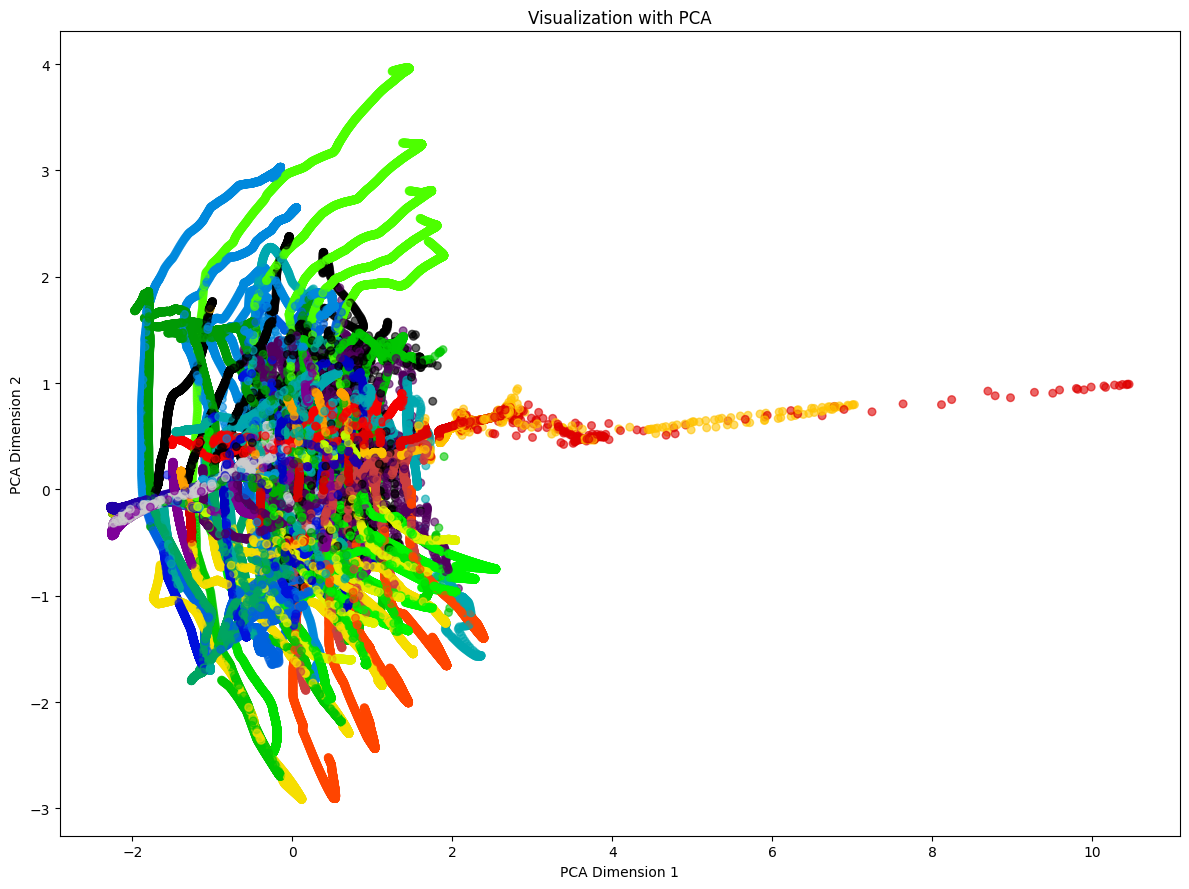

In [ ]:
plot_latent_space(latent_representations, labels, techniques=['PCA'], save_path=latent_space_path)

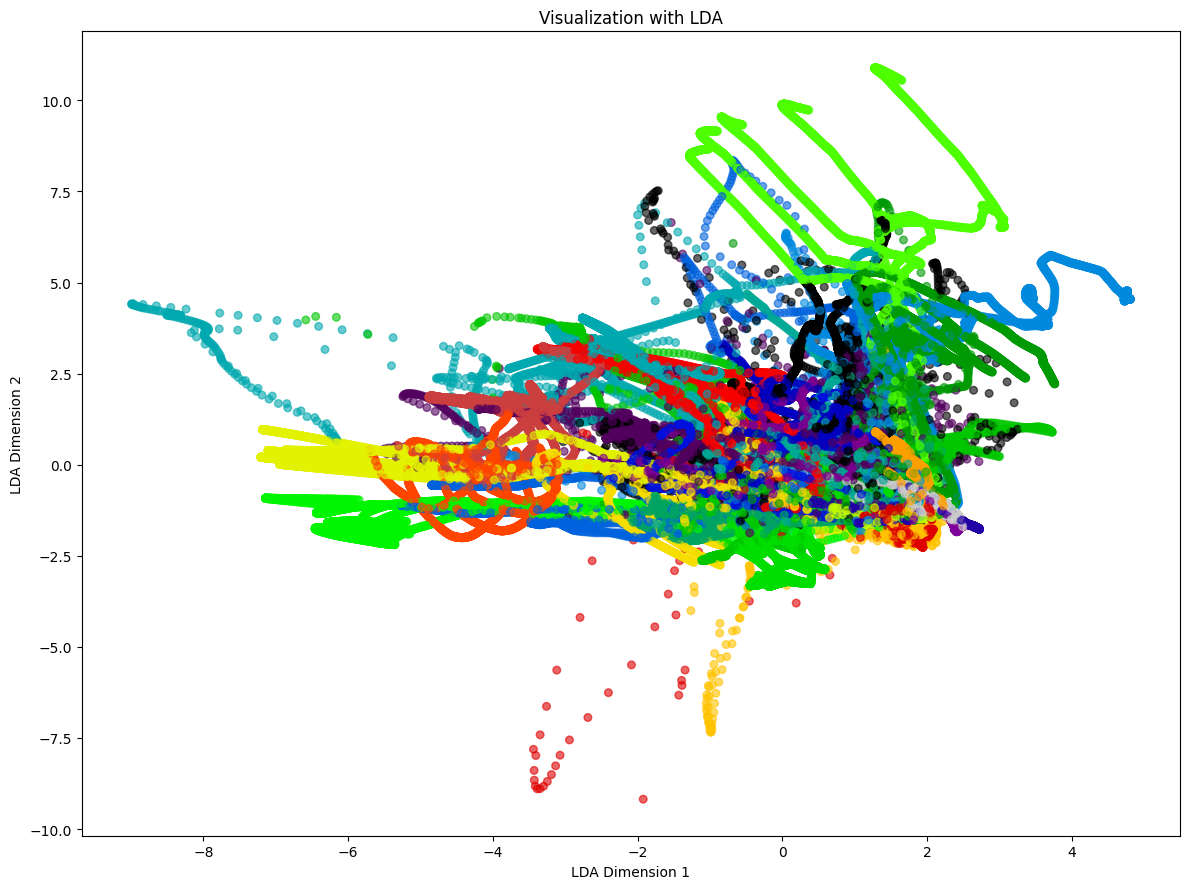

In [ ]:
plot_latent_space(latent_representations, labels, techniques=['LDA'])

In [ ]:
klk

In [ ]:
# plot_latent_space(latent_representations, labels, techniques=['UMAP'])

In [ ]:
# plot_latent_space(latent_representations, labels, techniques=['t-SNE'])

In [ ]:
def plot_combined_latent_space(
        real_data: np.ndarray,                # Real data samples.
        synthetic_data: np.ndarray,           # Synthetic data samples generated by a model.
        encoder,                              # Encoder function or model that predicts latent space representations.
        techniques: List[str] = ['PCA'],      # Techniques to use for reduction ('PCA', 't-SNE', 'UMAP', 'LDA').
        n_components: int = 2,                # Number of dimensions to reduce to.
        figsize: tuple = (12, 9),             # Size of the figure for each subplot.
        colors: Optional[List[str]] = None,   # Optional list of colors for the labels. If None, use random colors.
        save_path: Optional[str] = None,      # Optional path to save the plot image.
        **kwargs: Any                         # Additional keyword arguments for dimensionality reduction methods.
    )

In [ ]:
# Concatenate real and synthetic data
combined_data = np.concatenate([scaled_data, generation], axis=0)

# Create labels for real data ('0') and synthetic data ('1')
real_labels = np.zeros(scaled_data.shape[0])  # Assuming 0 for real
synthetic_labels = np.ones(generation.shape[0])  # Assuming 1 for synthetic
combined_labels = np.concatenate([real_labels, synthetic_labels], axis=0)

# Generate latent representations for the combined dataset
latent_outputs = vae.encoder.predict(combined_data)
latent_representations = latent_outputs[0]  # Assuming the mean of the latent space is the first output

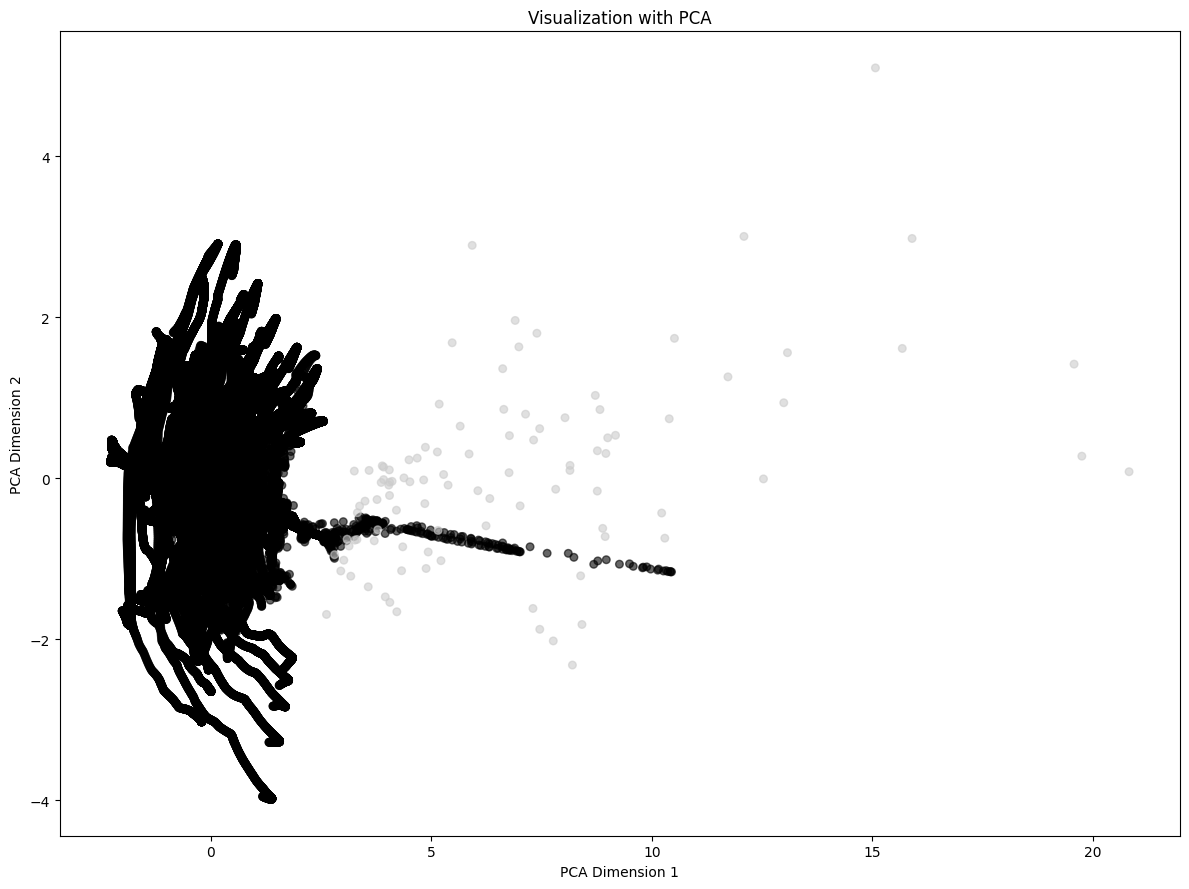

In [ ]:

# Plot latent space using the modified function
plot_latent_space(latent_representations, combined_labels, techniques=['PCA'], n_colors=2)

In [ ]:
tsgm.utils.visualize_tsne(X_train[:limit], y[:limit], X_gen, y_gen)

In [ ]:
wandb.finish()